Trial 10 Complete [00h 10m 29s]
val_loss: 0.00017225930544858178

Best val_loss So Far: 0.00017225930544858178
Total elapsed time: 01h 19m 56s
Epoch 1/50


C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 7.3615e-04 - val_loss: 0.0012
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 3.0078e-04 - val_loss: 1.6193e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 3.5001e-04 - val_loss: 2.0017e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 3.7017e-04 - val_loss: 2.6571e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 2.8712e-04 - val_loss: 3.5064e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 3.4758e-04 - val_loss: 2.6325e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 3.0539e-04 - val_loss: 5.5943e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 3.2470e-04 - val_loss: 0.0013
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 5.4230e-04 - val_loss: 6.0210e-04
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 3.8259e-04 - val_loss: 2.4159e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 2.9504e-04 - val_

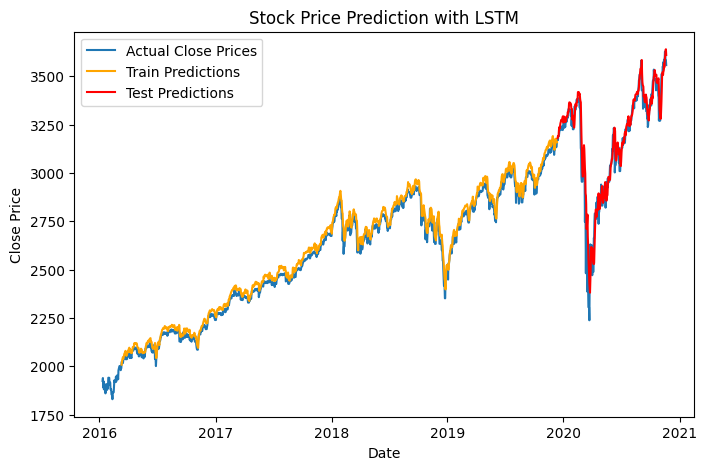

Mean Squared Error (MSE): 3745.3625854291186
Root Mean Squared Error (RMSE): 61.199367524747494
Mean Absolute Error (MAE): 39.967835029890786


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
from keras_tuner import RandomSearch

# Load the dataset
data = pd.read_csv('yahoo_stock.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Adding Technical Indicators (Moving Average and RSI)
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

def RSI(data, window_size):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['MA10'] = moving_average(data['Close'], 10)
data['MA50'] = moving_average(data['Close'], 50)
data['RSI'] = RSI(data['Close'], 14)

# Drop rows with NaN values (due to rolling calculations)
data.dropna(inplace=True)

# Use only relevant features for prediction
features = ['Close', 'MA10', 'MA50', 'RSI']
data = data[features]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert to supervised learning problem
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X, Y = create_dataset(scaled_data, look_back)

# Split into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Clear the previous tuner directory to avoid loading old models
import shutil
shutil.rmtree('keras_tuner_dir/stock_prediction', ignore_errors=True)

# Define a function to build the model for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_lstm1', min_value=50, max_value=200, step=50), 
                   return_sequences=True, 
                   input_shape=(look_back, len(features))))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_lstm2', min_value=50, max_value=200, step=50)))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_dense', min_value=10, max_value=100, step=10)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='keras_tuner_dir',
    project_name='stock_prediction'
)

# Search for the best hyperparameters
tuner.search(trainX, trainY, epochs=50, validation_split=0.2, verbose=1)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history = best_model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
trainPredict = best_model.predict(trainX)
testPredict = best_model.predict(testX)

# Inverse transform predictions to original scale
trainPredict = scaler.inverse_transform(np.concatenate((trainPredict, np.zeros((trainPredict.shape[0], len(features) - 1))), axis=1))[:, 0]
trainY = scaler.inverse_transform(np.concatenate((trainY.reshape(-1, 1), np.zeros((trainY.shape[0], len(features) - 1))), axis=1))[:, 0]
testPredict = scaler.inverse_transform(np.concatenate((testPredict, np.zeros((testPredict.shape[0], len(features) - 1))), axis=1))[:, 0]
testY = scaler.inverse_transform(np.concatenate((testY.reshape(-1, 1), np.zeros((testY.shape[0], len(features) - 1))), axis=1))[:, 0]

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(data.index, scaler.inverse_transform(scaled_data)[:, 0], label='Actual Close Prices')
plt.plot(data.index[look_back:len(trainPredict) + look_back], trainPredict, label='Train Predictions', color='orange')
plt.plot(data.index[len(data) - len(testPredict):], testPredict, label='Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(testY, testPredict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(testY, testPredict)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
